In [3]:
import pandas as pd

In [4]:
file_path = "/jf-training-home/NLP_Model/datasets_rw/input/unsmile_train_v1.0.tsv"

koreanUnsmileTrainData = pd.read_csv(file_path, delimiter='\t', encoding='utf-8')

In [5]:
print(koreanUnsmileTrainData.head())

                                                  문장  여성/가족  남성  성소수자  인종/국적  \
0                             일안하는 시간은 쉬고싶어서 그런게 아닐까      0   0     0      0   
1  아동성범죄와 페도버는 기록바 끊어져 영원히 고통 받는다. 무슬림 50퍼 근친이다. ...      0   0     0      0   
2  루나 솔로앨범 나왔을 때부터 머모 기운 있었음 ㅇㅇ Keep o  doin 진짜 띵...      0   0     0      0   
3  홍팍에도 어버이연합인가 보내요 뭐 이런뎃글 있는데 이거 어버이연합측에 신고하면 그쪽...      0   0     0      0   
4  아놔 왜 여기 댓들은 다 여자들이 김치녀라고 먼저 불렸다! 여자들은 더 심하게 그런...      1   0     0      0   

   연령  지역  종교  기타 혐오  악플/욕설  clean  개인지칭  
0   0   0   0      0      0      1     0  
1   0   0   1      0      0      0     0  
2   0   0   0      0      0      1     0  
3   0   0   0      0      0      1     0  
4   0   0   0      0      0      0     0  


In [6]:
print(koreanUnsmileTrainData.describe())

              여성/가족            남성          성소수자         인종/국적            연령  \
count  15005.000000  15005.000000  15005.000000  15005.000000  15005.000000   
mean       0.106564      0.089770      0.076041      0.115162      0.040187   
std        0.308569      0.285862      0.265073      0.319228      0.196403   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                 지역            종교         기타 혐오         악플/욕설         clean  \
count  15005.000000  15005.000000  15005.000000  15005.000000  15005.000000   
mean       0.070110      0.078707      0.037921      0.209464      0.249184   
std        0.255341      0.269290      0.191011    

# text 정제 적용 후 저장

In [7]:
from text_cleaning import cleaning_text
koreanUnsmileTrainData['문장'] = koreanUnsmileTrainData['문장'].apply(cleaning_text)
print(koreanUnsmileTrainData['문장'])

0                                   일안하는 시간은 쉬고싶어서 그런게 아닐까
1        아동성범죄와 페도버는 기록바 끊어져 영원히 고통 받는다 무슬림 50퍼 근친이다 10...
2        루나 솔로앨범 나왔을 때부터 머모 기운 있었음  keep o  doin 진짜 띵곡임...
3        홍팍에도 어버이연합인가 보내요 뭐 이런뎃글 있는데 이거 어버이연합측에 신고하면 그쪽...
4        아놔 왜 여기 댓들은 다 여자들이 김치녀라고 먼저 불렸다 여자들은 더 심하게 그런다...
                               ...                        
15000                                               께롱께롱께롱
15001                                갱상도가아니라 홍어지 개좃같은 홍어년들
15002                             말레이시아랑 인도네시아 여자 존나 못생겼던데
15003                                링크도 안박고 가서 글 쓰자고 선동하네
15004    멸치가 틀딱 짜증나서 트러블나면 조직적으로 좀스럽게 보복함ex 수건찜유도탄 틀한명한...
Name: 문장, Length: 15005, dtype: object


## 훈련 및 테스트 데이터 분할

In [8]:
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(
    koreanUnsmileTrainData['문장'].tolist(), koreanUnsmileTrainData['악플/욕설'].tolist(), test_size=0.2, random_state=42
)

## 데이터셋 및 데이터 로더 생성

In [9]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')


train_encodings = tokenizer.batch_encode_plus(
    train_texts, add_special_tokens=True, max_length=128, padding='max_length', truncation=True, return_tensors='pt'
)
test_encodings = tokenizer.batch_encode_plus(
    test_texts, add_special_tokens=True, max_length=128, padding='max_length', truncation=True, return_tensors='pt'
)

## 모델, 옵티마이저, 손실 함수 정의 및 평가 함수

In [10]:
import torch
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# 옵티마이저 및 손실 함수 정의
optimizer = AdamW(model.parameters(), lr=1e-5)
criterion = torch.nn.CrossEntropyLoss()

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

## 데이터셋 및 데이터 로더 생성

In [11]:
from koreanHateSpeechDataset import KoreanHateSpeechDataset
from torch.utils.data import DataLoader

# 데이터셋 생성
train_dataset = KoreanHateSpeechDataset(train_encodings, train_labels)
test_dataset = KoreanHateSpeechDataset(test_encodings, test_labels)

# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [12]:
from focal_loss import FocalLoss



focal_criterion = FocalLoss(alpha=1, gamma=2, reduction='mean')


## 훈련 및 루프

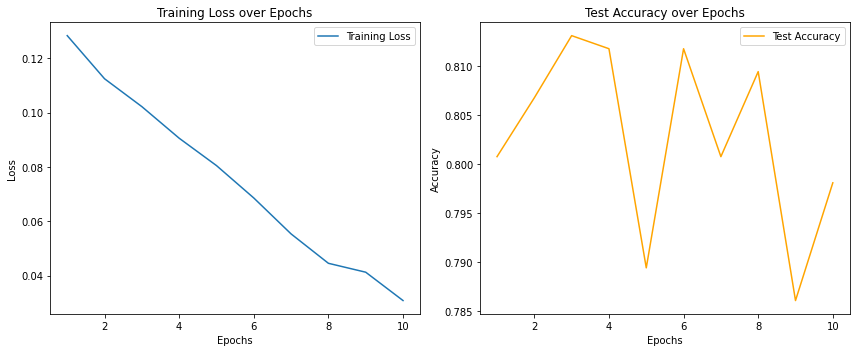

In [13]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from evaluate import evaluate
import torch

num_epochs = 10
losses = []
accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(model.device)
        labels = batch['labels'].to(model.device)
        optimizer.zero_grad()

        outputs = model(input_ids, labels=labels)
        loss = focal_criterion(outputs.logits, labels)
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        progress_bar.set_postfix(loss=total_loss / len(train_loader))

    avg_loss = total_loss / len(train_loader)
    test_accuracy = evaluate(model, test_loader)
    accuracies.append(test_accuracy)
    losses.append(avg_loss)

# Plotting the loss and test accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), accuracies, label='Test Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()
